In [16]:
dataset_name = "elb_request_count_8c0756"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [17]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import math
import warnings
warnings.filterwarnings('ignore')

# Preprocess dataset

In [18]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '5min', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '5min', data, method="linear")

# write to csv for htm
# data.to_csv("/home/cfreeman/Desktop/prefill/" + dataset_name + ".csv", index=False)

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="5min", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2014-04-12 17:24:00",
                      "2014-04-22 19:34:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2014-04-10 00:04:00
End date:  2014-04-24 00:39:00
Missing time stamps: 
 DatetimeIndex(['2014-04-10 11:34:00', '2014-04-13 03:44:00',
               '2014-04-14 00:04:00', '2014-04-16 05:04:00',
               '2014-04-16 11:04:00', '2014-04-17 15:14:00',
               '2014-04-18 07:54:00', '2014-04-20 04:14:00'],
              dtype='datetime64[ns]', freq=None)
Fill Missing Time Steps with Interpolation
Length:  4040
Time step size:  5min
Start Date:  2014-04-10 00:04:00
End Date:  2014-04-24 00:39:00
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [784, 3690]


# GLM

In [19]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='poisson', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

100%|██████████| 4040/4040 [00:00<00:00, 27222.40it/s]

Initial Mean 70.16089108910892
Initial StdDev 58.112736873883705



100%|██████████| 4040/4040 [00:00<00:00, 28351.75it/s]

eta:  0.5
lambda:  0.99
MSE:  inf
Initial Mean 70.16089108910892
Initial StdDev 58.112736873883705



100%|██████████| 4040/4040 [00:00<00:00, 25946.90it/s]

eta:  0.5
lambda:  0.999
MSE:  2988.649413963078
Initial Mean 70.16089108910892
Initial StdDev 58.112736873883705



100%|██████████| 4040/4040 [00:00<00:00, 26261.36it/s]

eta:  0.5
lambda:  0.9999
MSE:  3018.8406216209232
Initial Mean 70.16089108910892
Initial StdDev 58.112736873883705



100%|██████████| 4040/4040 [00:00<00:00, 28207.42it/s]

eta:  1
lambda:  0.99
MSE:  inf
Initial Mean 70.16089108910892
Initial StdDev 58.112736873883705



100%|██████████| 4040/4040 [00:00<00:00, 26455.09it/s]

eta:  1
lambda:  0.999
MSE:  3038.753600838962
Initial Mean 70.16089108910892
Initial StdDev 58.112736873883705


eta:  1
lambda:  0.9999
MSE:  3045.588403304301

best params:  eta 0.5 lambda 0.999


100%|██████████| 4040/4040 [00:00<00:00, 27919.55it/s]

Initial Mean 70.16089108910892
Initial StdDev 58.112736873883705


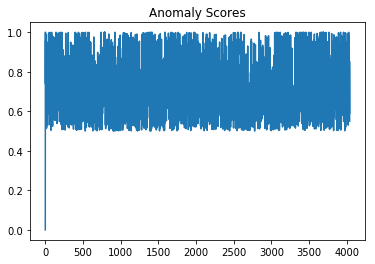

Time:  0.6545486450195312


['anomaly_scores/GLM/elb_request_count_8c0756']

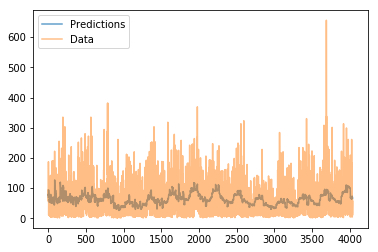

In [20]:
save_path = "anomaly_scores/GLM/" + dataset_name
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='poisson', 
                     eta=.5,
                     lambda_=.999,
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

In [6]:
# optimization step

step_sizes = [100, 200, 300, 400, 500]
seasonality_prior_scales = [1, 5, 10, 15, 20]
seasonality_modes = ["additive", "multiplicative"]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for seasonality_prior_scale in seasonality_prior_scales:
        for seasonality_mode in seasonality_modes:
            for changepoint_prior_scale in changepoint_prior_scales:
                
                mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                          daily_seasonality=True, 
                                          seasonality_prior_scale=seasonality_prior_scale,
                                          seasonality_mode=seasonality_mode,
                                          changepoint_prior_scale=changepoint_prior_scale,
                                          step_size=step_size,
                                          optimize=True)
                print("Step Size: ", step_size)
                print("Seasonality Prior Scale: ", seasonality_prior_scale)
                print("Seasonality Mode: ", seasonality_mode)
                print("Changepoint Prior Scale: ", changepoint_prior_scale)
                print("MSE: ",mse)
                
                key_str = "Step Size " + str(step_size) + " Seasonality Prior Scale " + str(seasonality_prior_scale) +" Seasonality Mode " + str(seasonality_mode) +" Changepoint Prior Scale" + str(changepoint_prior_scale)
                
                opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4208.974509687523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.010477331657


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.146549461886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.266687654867


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4173.086307590742


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4220.982875173195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4197.62979793764


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4186.999555613628


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4172.094702119948


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4167.12315048259


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4211.5284663093735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.359974879106


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.386978013708


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.605119810761


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.896773450142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4217.904179985792


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4196.722237014291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.032301455886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4173.906460875356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4164.215616158779


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4211.627492789385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.5521626485215


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.8660690209135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4182.028766551041


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4172.397160512767


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4218.477700313893


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4198.504289119096


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4186.994518456118


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4174.957316841184


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4163.632730089293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4213.511878449087


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.484912184349


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4192.1051535206225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.945381844393


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.759184739269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4220.0837112351755


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4198.397565392269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.170184225718


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4174.61477784793


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4166.096614963884


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4212.148798964531


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.565258041603


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.605132014466


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4177.77177056965


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.462550856346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4216.047453300572


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4197.20414420108


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.310365330174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4175.317466113689


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4164.587323007747


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4208.974509687523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.010477331657


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.146549461886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.266687654867


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4173.086307590742


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4220.982875173195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4197.62979793764


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4186.999555613628


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4172.094702119948


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4167.12315048259


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4211.5284663093735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.359974879106


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.386978013708


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.605119810761


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.896773450142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4217.904179985792


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4196.722237014291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.032301455886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4173.906460875356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4164.215616158779


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4211.627492789385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.5521626485215


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.8660690209135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4182.028766551041


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4172.397160512767


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4218.477700313893


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4198.504289119096


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4186.994518456118


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4174.957316841184


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4163.632730089293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4213.511878449087


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.484912184349


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4192.1051535206225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.945381844393


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.759184739269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4220.0837112351755


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4198.397565392269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.170184225718


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4174.61477784793


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4166.096614963884


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4212.148798964531


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.565258041603


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.605132014466


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4177.77177056965


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.462550856346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4216.047453300572


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4197.20414420108


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.310365330174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4175.317466113689


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4164.587323007747


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4208.974509687523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.010477331657


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.146549461886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.266687654867


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4173.086307590742


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4220.982875173195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4197.62979793764


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4186.999555613628


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4172.094702119948


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4167.12315048259


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4211.5284663093735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.359974879106


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.386978013708


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.605119810761


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.896773450142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4217.904179985792


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4196.722237014291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.032301455886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4173.906460875356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4164.215616158779


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4211.627492789385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.5521626485215


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.8660690209135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4182.028766551041


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4172.397160512767


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4218.477700313893


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4198.504289119096


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4186.994518456118


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4174.957316841184


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4163.632730089293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4213.511878449087


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.484912184349


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4192.1051535206225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.945381844393


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.759184739269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4220.0837112351755


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4198.397565392269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.170184225718


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4174.61477784793


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4166.096614963884


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4212.148798964531


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.565258041603


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.605132014466


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4177.77177056965


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.462550856346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4216.047453300572


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4197.20414420108


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.310365330174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4175.317466113689


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4164.587323007747


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4208.974509687523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.010477331657


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.146549461886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.266687654867


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4173.086307590742


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4220.982875173195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4197.62979793764


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4186.999555613628


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4172.094702119948


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4167.12315048259


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4211.5284663093735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.359974879106


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.386978013708


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.605119810761


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.896773450142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4217.904179985792


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4196.722237014291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.032301455886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4173.906460875356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4164.215616158779


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4211.627492789385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.5521626485215


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.8660690209135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4182.028766551041


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4172.397160512767


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4218.477700313893


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4198.504289119096


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4186.994518456118


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4174.957316841184


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4163.632730089293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4213.511878449087


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.484912184349


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4192.1051535206225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.945381844393


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.759184739269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4220.0837112351755


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4198.397565392269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.170184225718


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4174.61477784793


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4166.096614963884


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4212.148798964531


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.565258041603


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.605132014466


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4177.77177056965


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.462550856346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4216.047453300572


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4197.20414420108


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.310365330174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4175.317466113689


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4164.587323007747


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4208.974509687523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.010477331657


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.146549461886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.266687654867


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4173.086307590742


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4220.982875173195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4197.62979793764


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4186.999555613628


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4172.094702119948


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4167.12315048259


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4211.5284663093735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.359974879106


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.386978013708


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.605119810761


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.896773450142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4217.904179985792


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4196.722237014291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.032301455886


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4173.906460875356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4164.215616158779


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4211.627492789385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.5521626485215


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.8660690209135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4182.028766551041


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4172.397160512767


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4218.477700313893


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4198.504289119096


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4186.994518456118


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4174.957316841184


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4163.632730089293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4213.511878449087


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.484912184349


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4192.1051535206225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4178.945381844393


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.759184739269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4220.0837112351755


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4198.397565392269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.170184225718


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4174.61477784793


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4166.096614963884


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  4212.148798964531


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  4198.565258041603


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  4191.605132014466


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  4177.77177056965


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  4171.462550856346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  4216.047453300572


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  4197.20414420108


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  4187.310365330174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  4175.317466113689
Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  4164.587323007747

best params:  Step Size 100 Seasonality Prior Scale 10 Seasonality Mode multiplicative Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


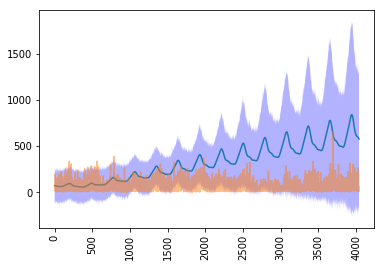

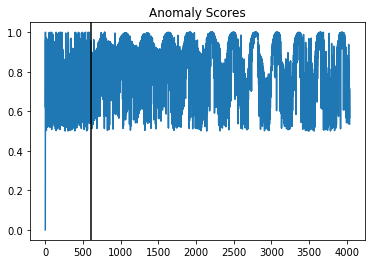

Time:  22.227356910705566


['anomaly_scores/Prophet/elb_request_count_8c0756']

In [7]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  daily_seasonality=True, 
                                  seasonality_prior_scale=10,
                                  seasonality_mode="multiplicative",
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

In [8]:
# only need one window size

# save_path = "anomaly_scores/Twitter/" + dataset_name
# output_dict = ad.twitterad(period=288,max_anoms=((.2/100) * ad.get_length())/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# HTM

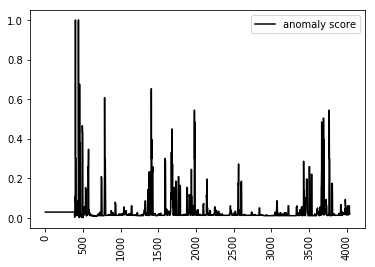

Time:  40.74


['anomaly_scores/HTM/elb_request_count_8c0756']

In [9]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", "40.74")
output_dict = {"Anomaly Scores": anomaly_scores, "Time": "40.74"}
joblib.dump(output_dict, save_path)

# STL Resid

In [10]:
# optimization step
swindows = ["periodic", 5,7,9,11]
sdegrees = [0,1,2]
twindows = [5,7,9,11]
tdegrees = [0,1,2]
inners = [1,2,3]
outers = [0,1]
opt_dict = {}

for swindow in swindows:
    for sdegree in sdegrees:
        for twindow in twindows:
            for tdegree in tdegrees:
                for inner in inners:
                    for outer in outers:
                        
                        print("swindow: ", swindow)
                        print("sdegree: ", sdegree)
                        print("twindow: ", twindow)
                        print("tdegree: ", tdegree)
                        print("inner: ", inner)
                        print("outer: ", outer)
                        
                        
                        try:
  
                            stl_resid_sum = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=288, swindow=swindow, 
                                                         sdegree=sdegree, twindow=twindow, tdegree=tdegree, inner=inner, 
                                                         outer=outer, fill_option="linear", optimize=True)


                            print("STL Resid Sum: ",stl_resid_sum)

                            key_str = "swindow " + str(swindow) + " sdegree " + str(sdegree) +" twindow " + str(twindow) +" tdegree " + str(tdegree) +" inner " + str(inner) +" outer " + str(outer)

                            opt_dict[key_str] = stl_resid_sum

                        except:
                            print("Fail")
                            continue

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  418297.3507158588
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  418494.6544220944
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  418161.41944136523
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  418297.3507158588
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  418094.5882069483
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  418214.3937849225
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  0


R stlplus completed: 606 no missing True
STL Resid Sum:  509196.2270546837
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  778816.851356316
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  779075.8725955009
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  778623.9373032292
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  778816.851356316
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  778537.456779518
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  778696.530839732

R stlplus completed: 606 no missing True
STL Resid Sum:  325190.9851377204
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  738024.9472844102
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  738330.7281494174
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  737793.6271482846
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  738024.9472844102
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  737688.4758892249
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  737881.3601263994
s

R stlplus completed: 606 no missing True
STL Resid Sum:  1218.0204673887747
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  626074.497594608
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  626389.0213848785
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  625868.4304504823
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  626074.497594608
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  625776.8749832667
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  625945.2931627745
sw

R stlplus completed: 606 no missing True
STL Resid Sum:  644893.436195045
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  333400.10522517795
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  326664.7909101156
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  333959.01372797205
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  333400.10522517795
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  333918.672573058
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  333950.1996465935
swindow:  5
sdegree:  0
twindow:  5
tdegre

R stlplus completed: 606 no missing True
STL Resid Sum:  613000.1331066018
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  614959.5406047683
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  614858.9943053363
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  614911.9980909076
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  614988.2210922524
swindow:  5
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  602416.7300362403
swindow:  5
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  600251.0106393216
swindow:  5
sdegree:  0
twindow:  11


R stlplus completed: 606 no missing True
STL Resid Sum:  25653.194857675728
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  25545.544359339827
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  25609.569361183385
swindow:  5
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  25619.900807756992
swindow:  5
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  26050.87375898784
swindow:  5
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  25532.132364822883
swindow:  5
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  25619.900807756992
swindow:  5
sdegree:  1
twindow:  9
t

Fail
swindow:  5
sdegree:  2
twindow:  9
tdegree:  0
inner:  2
outer:  1
606
Fail
swindow:  5
sdegree:  2
twindow:  9
tdegree:  0
inner:  3
outer:  0
606
Fail
swindow:  5
sdegree:  2
twindow:  9
tdegree:  0
inner:  3
outer:  1
606
Fail
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  1
outer:  0
606
Fail
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  nan
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  2
outer:  0
606
Fail
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  2
outer:  1
606
Fail
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  3
outer:  0
606
Fail
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  3
outer:  1
606
Fail
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  1
outer:  0
606
Fail
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  nan
swindow:  5
sdegree:  2
twindow:  9


R stlplus completed: 606 no missing True
STL Resid Sum:  677212.307162682
swindow:  7
sdegree:  0
twindow:  9
tdegree:  0
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  676994.3096268626
swindow:  7
sdegree:  0
twindow:  9
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  677094.0180465478
swindow:  7
sdegree:  0
twindow:  9
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  677212.307162682
swindow:  7
sdegree:  0
twindow:  9
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  677009.2556831061
swindow:  7
sdegree:  0
twindow:  9
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  677162.4166940885
swindow:  7
sdegree:  0
twindow:  9
tdegree:  1
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  676097.1597684796
swindow:  7
sdegree:  0
twindow:  9
tdegree: 

R stlplus completed: 606 no missing True
STL Resid Sum:  27743.54600435052
swindow:  7
sdegree:  1
twindow:  7
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  27842.746929431258
swindow:  7
sdegree:  1
twindow:  7
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  27707.907806079475
swindow:  7
sdegree:  1
twindow:  7
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  27778.09596384885
swindow:  7
sdegree:  1
twindow:  7
tdegree:  1
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  27776.636884177726
swindow:  7
sdegree:  1
twindow:  7
tdegree:  1
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  27924.767409755896
swindow:  7
sdegree:  1
twindow:  7
tdegree:  1
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  27676.64595331952
swindow:  7
sdegree:  1
twindow:  7
tde

Fail
swindow:  7
sdegree:  2
twindow:  5
tdegree:  1
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  nan
swindow:  7
sdegree:  2
twindow:  5
tdegree:  1
inner:  2
outer:  0
606
Fail
swindow:  7
sdegree:  2
twindow:  5
tdegree:  1
inner:  2
outer:  1
606
Fail
swindow:  7
sdegree:  2
twindow:  5
tdegree:  1
inner:  3
outer:  0
606
Fail
swindow:  7
sdegree:  2
twindow:  5
tdegree:  1
inner:  3
outer:  1
606
Fail
swindow:  7
sdegree:  2
twindow:  5
tdegree:  2
inner:  1
outer:  0
606
Fail
swindow:  7
sdegree:  2
twindow:  5
tdegree:  2
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  nan
swindow:  7
sdegree:  2
twindow:  5
tdegree:  2
inner:  2
outer:  0
606
Fail
swindow:  7
sdegree:  2
twindow:  5
tdegree:  2
inner:  2
outer:  1
606
Fail
swindow:  7
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  0
606
Fail
swindow:  7
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
606
Fail
swindow:  7
sdegree:  2
twindow:  7


R stlplus completed: 606 no missing True
STL Resid Sum:  1241.9363815653992
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  601347.6014660136
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  600828.768808734
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  601185.4238962677
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  601347.6014660136
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  601103.372113874
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  601253.1731663253
swindow:  9
sdegree:  0
twindow:  7
tdegree:

R stlplus completed: 606 no missing True
STL Resid Sum:  15933.173841662323
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  15846.041802935504
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  15919.767185139832
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  15820.467265091289
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  15871.034655139905
swindow:  9
sdegree:  1
twindow:  5
tdegree:  1
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  15770.794167783675
swindow:  9
sdegree:  1
twindow:  5
tdegree:  1
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  15743.519517772686
swindow:  9
sdegree:  1
twindow:  5


R stlplus completed: 606 no missing True
STL Resid Sum:  37466.4036206463
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  37295.15357987651
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  37376.00116022025
swindow:  9
sdegree:  1
twindow:  11
tdegree:  1
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  36756.60651929218
swindow:  9
sdegree:  1
twindow:  11
tdegree:  1
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  37272.63339989704
swindow:  9
sdegree:  1
twindow:  11
tdegree:  1
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  36604.8247410691
swindow:  9
sdegree:  1
twindow:  11
tdegree:  1
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  36756.60651929218
swindow:  9
sdegree:  1
twindow:  11
td

Fail
swindow:  9
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  0
606
Fail
swindow:  9
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  1
606
Fail
swindow:  11
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  409084.559877332
swindow:  11
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  408456.956560221
swindow:  11
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  408959.6075211503
swindow:  11
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  409084.559877332
swindow:  11
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  408894.7041782789
swindow:  11
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no m

R stlplus completed: 606 no missing True
STL Resid Sum:  761234.4256402863
swindow:  11
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  761184.5708796077
swindow:  11
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  761057.8194643555
swindow:  11
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  761234.4256402863
swindow:  11
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  760976.8727116762
swindow:  11
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  761125.5250946364
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  744736.7531487753
swindow:  11
sdegree:  0
twindo

R stlplus completed: 606 no missing True
STL Resid Sum:  37906.22424099097
swindow:  11
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  38027.62544641758
swindow:  11
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  37867.07497212022
swindow:  11
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  37945.48714276887
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  37963.593112670365
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  38449.23538801911
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  37827.0112532671
swindow:  11
sdegree:  1
twindow:  9


R stlplus completed: 606 no missing True
STL Resid Sum:  387309.3101381731
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  392613.77648390335
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  391481.7873030962
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  387290.1422466744
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  375241.4953540384
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
606
R stlplus completed: 606 no missing True
STL Resid Sum:  392345.349060009
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  1
606
R stlplus completed: 606 no missing True
STL Resid Sum:  387290.1422466744
swindow:  11
sdegree:  2
twindow:  7


In [11]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=288, swindow=11, 
             sdegree=2, twindow=5, tdegree=2, inner=3, 
             outer=1, fill_option="linear", optimize=False)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

4040
R stlplus completed: 4040 no missing True
Time:  1.0807106494903564


['anomaly_scores/stl/elb_request_count_8c0756']

# windowed Gaussian

In [12]:
# optimization step
step_sizes = [100, 200, 300, 400, 500]

opt_dict = {}

for step_size in step_sizes:
    print("Step size: ", step_size)
    output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                       step_size = step_size, 
                                       optimize=True,
                                       plot_anomaly_score=False)
    print("MSE: ", output_dict["MSE"])
    opt_dict[step_size] = output_dict["MSE"]

best_step_size = min(opt_dict, key=opt_dict.get)
print("\nbest step size: ", best_step_size)

Step size:  100
MSE:  3416.908913482312
Step size:  200
MSE:  3416.908913482312
Step size:  300
MSE:  3416.908913482312
Step size:  400
MSE:  3416.908913482312
Step size:  500
MSE:  3416.908913482312

best step size:  100


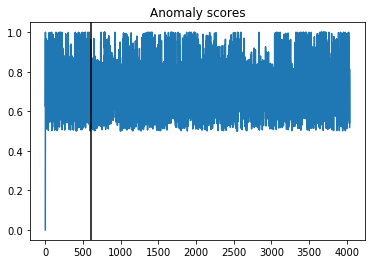

Time:  0.1394345760345459


['anomaly_scores/windowed_gaussian/elb_request_count_8c0756']

In [13]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name

output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                   step_size = best_step_size, 
                                   plot_anomaly_score=True)

print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

In [14]:
# only need one window size

# save_path = "anomaly_scores/hotsax/" + dataset_name
# output_dict = ad.hotsax(win_size=50, num_discords=int((.2/100) * ad.get_length()),
#                a_size=3, paa_size=3, z_threshold=0.01,
#                plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# SARIMA


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 6662.362
 ARIMA(0,0,0) with non-zero mean : 6660.121
 ARIMA(1,0,0) with non-zero mean : 6659.433
 ARIMA(0,0,1) with non-zero mean : 6658.4
 ARIMA(0,0,0) with zero mean     : 6658.586
 ARIMA(1,0,1) with non-zero mean : 6659.636
 ARIMA(0,0,2) with non-zero mean : 6658.08
 ARIMA(1,0,2) with non-zero mean : 6658.691
 ARIMA(0,0,3) with non-zero mean : 6658.749
 ARIMA(1,0,3) with non-zero mean : 6659.447
 ARIMA(0,0,2) with zero mean     : 6656.461
 ARIMA(0,0,1) with zero mean     : 6656.784
 ARIMA(1,0,2) with zero mean     : 6657.116
 ARIMA(0,0,3) with zero mean     : 6657.132
 ARIMA(1,0,1) with zero mean     : 6658.004
 ARIMA(1,0,3) with zero mean     : 6657.652

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,2) with zero mean     : 6656.467

 Best model: Regression with ARIMA(0,0,2) errors 



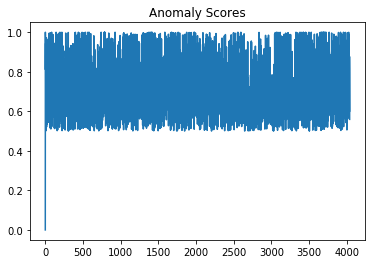

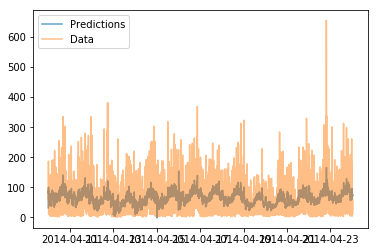

Time:  5.59909200668335


['anomaly_scores/SARIMA_auto/elb_request_count_8c0756']

In [15]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, s=288, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Anomalous

In [16]:
# only need one window size

# save_path = "anomaly_scores/anomalous/" + dataset_name
# output_dict = ad.anomalous(ts_length=100,
#                            upper=(.2/100) * ad.get_length(),
#                            plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)